In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import torchvision
from torchvision import datasets, models, transforms

In [3]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [4]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageClassifierData as ImageClassifierData
from Transforms.ImageTransforms import *

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 770', True)

In [7]:
def open_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(req.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [8]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [9]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [10]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [11]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [12]:
def bbtohw(a): 
    """Bounding box to Height width.

    Args:
        param1 (arr): [xmin, ymin, xmax, ymax] where (xmin, ymin) 
            and (xmax, ymax) represent the top left and bottom 
            right corners of the bounding box

    Returns:
        arr: [xmin, ymin, width, height]

    """
    return [a[0],a[1],a[2]-a[0],a[3]-a[1]]

assert bbtohw([2, 5, 10, 20]) == [2, 5, 8, 15]

In [13]:
DATA_PATH = Path('F:/fastai/courses/dl2/data/road_damage_dataset')

In [14]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [15]:
examples = pd.read_csv(DATA_PATH/'train_labels.csv')
images = split(examples, 'filename')

In [16]:
def print_example(example, ax=None):
    im = open_image(DATA_PATH/example.filename)
    if ax is not None:
        show_img(im, ax=ax)
    else:
        ax = show_img(im)
    for index, row in example.object.iterrows():
        bb = bbtohw([row['xmin'], row['ymin'], row['xmax'], row['ymax']]) # Bounding box converted to height width
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], row['class']) 

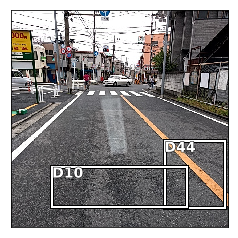

In [17]:
print_example(images[0])

In [18]:
im = open_image(DATA_PATH/images[1].filename)

In [19]:
flip = RandomHorizontalFlip()
crop = RandomCrop(300)
lighting = RandomLighting(0.5, 0.5)
scale = RandomScale(600, (0,1))

In [20]:
#show_img(im)
#show_img(flip(im, 0)[0])
#show_img(crop(im, 0)[0])
#show_img(lighting(im, 0)[0])
#show_img(scale(im, 0)[0])

In [21]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [22]:
mc = [set([row['class'] for index, row in img.object.iterrows()]) for img in images]
mcs = [' '.join(label for label in labels) for labels in mc]
print(mc[0:4])
print(mcs[0:4])

"\nmc = [set([row['class'] for index, row in img.object.iterrows()]) for img in images]\nmcs = [' '.join(label for label in labels) for labels in mc]\nprint(mc[0:4])\nprint(mcs[0:4])\n"

In [23]:
df = pd.DataFrame({'filename': [img.filename for img in images], 'class': mcs}, columns=['filename','class'])
df.to_csv(MULTICLASS_CSV_PATH, index=False)

"\ndf = pd.DataFrame({'filename': [img.filename for img in images], 'class': mcs}, columns=['filename','class'])\ndf.to_csv(MULTICLASS_CSV_PATH, index=False)\n"